<a href="https://colab.research.google.com/github/De-Par/Colabs/blob/main/Max_Bipartite_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#@title Cборка проекта

# Enter: ctrl + F9

In [79]:
#@title Установка солвера

!pip install cplex docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
#@title Импорт библиотек

import cplex
import docplex
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from collections import defaultdict

In [81]:
#@title Реализация алгоритма Куна

def create_adj_list(adj_mat):
    adj_list = []
    n = len(adj_mat)

    for i in range(n):
        adj_list.append([j for j in range(n) if adj_mat[i][j] == 1])
    return adj_list

def dfs(graph, v, used, pair):
    if used[v]:
        return False

    used[v] = True
    for x in graph[v]:
        if (pair[x] == -1 or dfs(graph, pair[x], used, pair)):
            pair[x] = v
            return True
    return False

def solve_with_kuhn_alg(graph):
    n = len(graph)
    pair = [-1]*n
    cnt = 0

    for i in range(n):
        used = [0]*n
        if (dfs(graph, i, used, pair)):
            cnt += 1
    return cnt

In [82]:
#@title Реализация улучшенного алгоритма Куна

def solve_with_impr_kuhn_alg(graph):
    n = len(graph)
    pair = [-1]*n
    ans = 0
    used = [0]*n
    for i in range(n):
        for j in range(len(graph[i])):
            if(pair[graph[i][j]] == -1):
                pair[graph[i][j]] = i
                used[i] = True
                ans += 1
                break
    for i in range(n):
        used_1 = [0]*n
        if used[i]: continue
        if (dfs(graph, i, used_1, pair)):
            ans += 1
    return ans

In [83]:
#@title Реализация алгоритма Форда-Фалкерсона (максимальное паросочетание)

def bpm(graph, u, matchR, seen):
    for v in range(len(graph[0])):
        if graph[u][v] and seen[v] == False:
            seen[v] = True

            if matchR[v] == -1 or bpm(graph, matchR[v], matchR, seen):
                matchR[v] = u
                return True

    return False

def max_bpm(graph):
    matchR = [-1]*len(graph[0])
    result = 0

    for i in range(len(graph)):
        seen = [False]*len(graph[0])
        if bpm(graph, i, matchR, seen):
            result += 1

    return result

def solve_with_ford_alg(graph):
    return max_bpm(graph)

In [84]:
#@title Реализация алгоритма Форда-Фалкерсона (максимальная пропускная способность)

def bfs(graph, s, t, parent):
    visited = [False]*len(graph)
    visited[s] = True
    queue = []
    queue.append(s)
    
    while queue:
        u = queue.pop(0)
        for ind, val in enumerate(graph[u]):
            if visited[ind] == False and val > 0:
                queue.append(ind)
                visited[ind] = True
                parent[ind] = u

    return True if visited[t] else False

def mx_flow(graph, source, sink):
    parent = [-1]*len(graph)
    max_flow = 0

    while bfs(graph, source, sink, parent):
        path_flow = float("inf")
        s = sink

        while(s != source):
            path_flow = min(path_flow, graph[parent[s]][s])
            s = parent[s]
        max_flow += path_flow
        v = sink

        while(v != source):
            u = parent[v]
            graph[u][v] -= path_flow
            graph[v][u] += path_flow
            v = parent[v]

    return max_flow

def mx_flow_ford_alg(graph):
    return mx_flow(graph, 0, len(graph) - 1)


In [85]:
#@title Решение задачи солвером

def solve_with_cplex(graph):
    global cplex_time_0
    n = len(graph)
    matching_model = Model("matching")
    x = matching_model.binary_var_list(n*n, name="x")
    obj_fn = sum(x[i + n*j]*graph[j][i] for j in range(n) for i in range(n))

    for i in range(n):
        matching_model.add_constraint(sum(x[i + n*j] for j in range(n)) <= 1)
        matching_model.add_constraint(sum(x[j + n*i] for j in range(n)) <= 1)

    matching_model.set_objective("max", obj_fn)
    start = time.time()
    sol = matching_model.solve()
    cplex_time_0 += time.time() - start

    return (int(sol.objective_value))

In [86]:
#@title Генерация матрицы смежности двудольного графа

def create_adj_mat(n_vert):
    graph = [[0]*n_vert for j in range(n_vert)]

    for j in range(n_vert):
        for k in range(n_vert):
            graph[j][k] = np.random.choice(np.arange(0, 2), p=[0.9, 0.1])
    return graph

In [113]:
#@title Вывод результатов

def print_answer(sol, ver_dl, is_verb):
    algo = ["Куна", "Куна+", "Форда"]

    if is_verb:
        i = 0
        for n_vert in ver_dl:
            print(f"Решения солвера для n = {n_vert}:")
            print(sol[0][i])
            print(f"Решения алгоритма Куна для n = {n_vert}:")
            print(sol[1][i])
            print(f"Решения алгоритма Куна+ для n = {n_vert}:")
            print(sol[2][i])
            print(f"Решения алгоритма Форда для n = {n_vert}:")
            print(sol[3][i])
            print()
            i += 1
    else:
        for n_v in ver_dl:
            i = 0
            print()
            for ans in sol[1:]:
                f = True
                for a, b in zip(sol[0][i], ans[i]):
                    if a != b:
                        f = False
                        break
                sym = (" " if i == 0 else "") + ("✅" if f else "❌")
                print(f"Сходство решений алгоритма {algo[i]} с солвером для n = {n_v}: {sym}")
                i += 1


Сходство решений алгоритма Куна с солвером для n = 10:  ✅
Сходство решений алгоритма Куна+ с солвером для n = 10: ✅
Сходство решений алгоритма Форда с солвером для n = 10: ✅

Сходство решений алгоритма Куна с солвером для n = 20:  ✅
Сходство решений алгоритма Куна+ с солвером для n = 20: ✅
Сходство решений алгоритма Форда с солвером для n = 20: ✅

Сходство решений алгоритма Куна с солвером для n = 30:  ✅
Сходство решений алгоритма Куна+ с солвером для n = 30: ✅
Сходство решений алгоритма Форда с солвером для n = 30: ✅





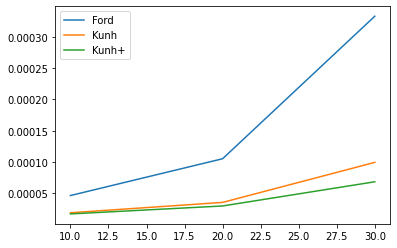

In [117]:
#@title Основная реализация

# Requirement: FROM + N*STEP == MAX_VERT, where N is natural

IS_VERBOSE = False
CPLEX_LIMIT = 30
NUM_TESTS = 100
MAX_VERT = 30
FROM = 10
STEP = 10

cplex_sol, kunh_sol, kunh_impr_sol, ford_sol = [], [], [], []
kunh_time, kunh_impr_time, ford_time = [], [], []
ver_dim_list = [i for i in range(FROM, MAX_VERT + 1, STEP)]

for n_vert in ver_dim_list:
    cplex_sol_ex, kunh_sol_ex, kunh_impr_sol_ex, ford_sol_ex = [], [], [], []
    kunh_time_0, kunh_impr_time_0, ford_time_0 = 0, 0, 0
  
    for n_test in range(NUM_TESTS):
        adj_mat = create_adj_mat(n_vert)

        if n_vert <= CPLEX_LIMIT:
            cplex_sol_ex.append(solve_with_cplex(adj_mat))

        # ford-fulkerson
        start = time.time()
        ford_sol_ex.append(solve_with_ford_alg(adj_mat))
        ford_time_0 += time.time() - start

        # data migration
        adj_list = create_adj_list(adj_mat)  

        # kunh
        start = time.time()
        kunh_sol_ex.append(solve_with_kuhn_alg(adj_list))
        kunh_time_0 += time.time() - start

        # kunh improved
        start = time.time()
        kunh_impr_sol_ex.append(solve_with_impr_kuhn_alg(adj_list))
        kunh_impr_time_0 += time.time() - start

    kunh_time.append(kunh_time_0/NUM_TESTS)
    kunh_impr_time.append(kunh_impr_time_0/NUM_TESTS)
    ford_time.append(ford_time_0/NUM_TESTS)

    cplex_sol.append(cplex_sol_ex)
    kunh_sol.append(kunh_sol_ex)
    kunh_impr_sol.append(kunh_impr_sol_ex)
    ford_sol.append(ford_sol_ex)


solutions = [cplex_sol, kunh_sol, kunh_impr_sol, ford_sol]
print_answer(solutions, ver_dim_list, IS_VERBOSE)

print("\n\n")
plt.plot(ver_dim_list, ford_time, label="Ford")
plt.plot(ver_dim_list, kunh_time, label="Kunh")
plt.plot(ver_dim_list, kunh_impr_time, label="Kunh+")

plt.legend()
plt.show()